In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from niwidgets import NiftiWidget
import tensorflow as tf
from tensorflow.keras.preprocessing.image import * 
from tensorflow import keras
from config import *
from modelIO import *
from model import *
from segmentation import *
from display import *
from dataAugmentation import *
import math
import random
from skimage.util import montage, crop
from tensorflow.python.client import device_lib
from tensorflow.keras.metrics import MeanIoU,BinaryCrossentropy,Accuracy,Precision,Recall
from skimage.transform import rescale, resize, downscale_local_mean,rotate
from skimage import data, color
from scipy import ndimage
from scipy import misc
from numpy import fliplr
from PIL import Image
from datetime import *
from sklearn.model_selection import KFold
#print(device_lib.list_local_devices())
#tf.config.experimental.list_physical_devices('GPU')

/home/jain0000/miniconda3/envs/segment2/lib/python3.7/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
(train_images,train_labels,test_images,test_labels) = load_data('segmentation',
           unet3d(4),TYPE)
print(train_images.shape,train_labels.shape)
      

(10, 40, 40, 40) (10, 40, 40, 40)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity 

<Figure size 1080x1080 with 0 Axes>

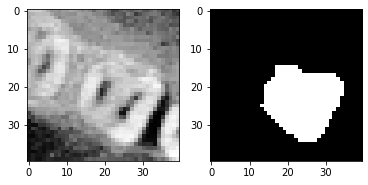

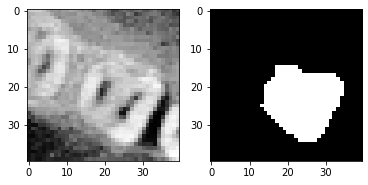

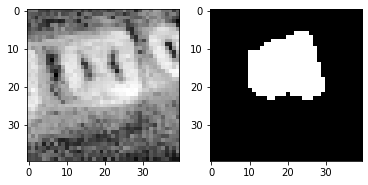

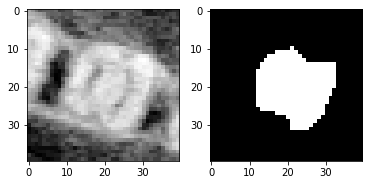

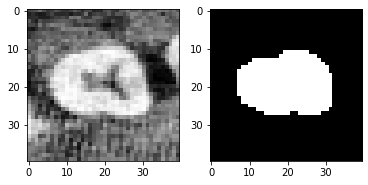

In [3]:
train_loader = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
validation_loader = tf.data.Dataset.from_tensor_slices((test_images,test_labels))
    
train_dataset = (
train_loader
.shuffle(train_dataset_batch_size)
.map(train_preprocessing)
.map(fixup_shape)
.batch(train_dataset_batch_size)  
.prefetch(train_dataset_batch_size)
)
# Only rescale.
validation_dataset = (
    validation_loader
    .map(validation_preprocessing)
    .map(fixup_shape)
    .batch(test_dataset_batch_size)
    .prefetch(test_dataset_batch_size)
)
      
num = 5
data = train_dataset.take(5)
showDataset(data, num)    

In [5]:
model= get_model('segmentation')
model.summary()    

Model: "UNET3D-L4-F32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40, 40, 40,  0                                            
__________________________________________________________________________________________________
conv3d_15 (Conv3D)              (None, 40, 40, 40, 3 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 40, 40, 40, 3 128         conv3d_15[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Relu_14 (TensorFlow [(None, 40, 40, 40,  0           batch_normalization_25[0][0]     
______________________________________________________________________________________

In [6]:
initial_learning_rate = LR_RATE
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate, decay_steps=100, decay_rate=0.9, staircase=True) 
loss_fn = Dice()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
name  = '-'.join(['UNET3D-Tooth','segmentation',str(IMAGE_HEIGHT),str(IMAGE_WIDTH),str(IMAGE_DEPTH),datetime.now().strftime("%Y%m%d-%H%M%S"),'.h5'])   
logdir = LOG_PATH + name
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

In [10]:

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss = loss_fn, metrics=['accuracy'])


model.fit(train_dataset,validation_data=(validation_dataset),
            epochs=NUM_OF_EPOCHS,
            shuffle=True,
            callbacks=[tensorboard_callback],
            )


Epoch 1/2000
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9630WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.256593). Check your callbacks.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argume

2/2 [==============================] - 0s 145ms/step - loss: 0.0026 - accuracy: 0.9938 - val_loss: 0.0554 - val_accuracy: 0.8798
Epoch 45/2000
2/2 [==============================] - 0s 159ms/step - loss: 0.0028 - accuracy: 0.9930 - val_loss: 0.0557 - val_accuracy: 0.8788
Epoch 46/2000
2/2 [==============================] - 0s 137ms/step - loss: 0.0026 - accuracy: 0.9942 - val_loss: 0.0550 - val_accuracy: 0.8800
Epoch 47/2000
2/2 [==============================] - 0s 136ms/step - loss: 0.0026 - accuracy: 0.9940 - val_loss: 0.0553 - val_accuracy: 0.8802
Epoch 48/2000
2/2 [==============================] - 0s 139ms/step - loss: 0.0025 - accuracy: 0.9941 - val_loss: 0.0544 - val_accuracy: 0.8820
Epoch 49/2000
2/2 [==============================] - 0s 135ms/step - loss: 0.0025 - accuracy: 0.9941 - val_loss: 0.0551 - val_accuracy: 0.8810
Epoch 50/2000
2/2 [==============================] - 0s 142ms/step - loss: 0.0024 - accuracy: 0.9945 - val_loss: 0.0546 - val_accuracy: 0.8816
Epoch 51/2000

2/2 [==============================] - 0s 143ms/step - loss: 0.0017 - accuracy: 0.9961 - val_loss: 0.0487 - val_accuracy: 0.8951
Epoch 102/2000
2/2 [==============================] - 0s 143ms/step - loss: 0.0018 - accuracy: 0.9956 - val_loss: 0.0494 - val_accuracy: 0.8940
Epoch 103/2000
2/2 [==============================] - 0s 142ms/step - loss: 0.0016 - accuracy: 0.9960 - val_loss: 0.0485 - val_accuracy: 0.8959
Epoch 104/2000
2/2 [==============================] - 0s 142ms/step - loss: 0.0016 - accuracy: 0.9966 - val_loss: 0.0491 - val_accuracy: 0.8949
Epoch 105/2000
2/2 [==============================] - 0s 141ms/step - loss: 0.0016 - accuracy: 0.9962 - val_loss: 0.0483 - val_accuracy: 0.8962
Epoch 106/2000
2/2 [==============================] - 0s 160ms/step - loss: 0.0016 - accuracy: 0.9964 - val_loss: 0.0448 - val_accuracy: 0.9025
Epoch 107/2000
2/2 [==============================] - 0s 151ms/step - loss: 0.0016 - accuracy: 0.9966 - val_loss: 0.0466 - val_accuracy: 0.8991
Epoch 1

Epoch 158/2000
2/2 [==============================] - 0s 138ms/step - loss: 0.0010 - accuracy: 0.9981 - val_loss: 0.0342 - val_accuracy: 0.9239
Epoch 159/2000
2/2 [==============================] - 0s 149ms/step - loss: 9.5318e-04 - accuracy: 0.9980 - val_loss: 0.0356 - val_accuracy: 0.9213
Epoch 160/2000
2/2 [==============================] - 0s 141ms/step - loss: 0.0011 - accuracy: 0.9974 - val_loss: 0.0350 - val_accuracy: 0.9226
Epoch 161/2000
2/2 [==============================] - 0s 140ms/step - loss: 0.0010 - accuracy: 0.9981 - val_loss: 0.0357 - val_accuracy: 0.9213
Epoch 162/2000
2/2 [==============================] - 0s 144ms/step - loss: 9.0888e-04 - accuracy: 0.9982 - val_loss: 0.0359 - val_accuracy: 0.9210
Epoch 163/2000
2/2 [==============================] - 0s 140ms/step - loss: 9.0289e-04 - accuracy: 0.9979 - val_loss: 0.0344 - val_accuracy: 0.9239
Epoch 164/2000
2/2 [==============================] - 0s 149ms/step - loss: 9.1773e-04 - accuracy: 0.9983 - val_loss: 0.0349

2/2 [==============================] - 0s 161ms/step - loss: 4.3209e-04 - accuracy: 0.9993 - val_loss: 0.0349 - val_accuracy: 0.9240
Epoch 214/2000
2/2 [==============================] - 0s 146ms/step - loss: 4.3715e-04 - accuracy: 0.9993 - val_loss: 0.0349 - val_accuracy: 0.9242
Epoch 215/2000
2/2 [==============================] - 0s 145ms/step - loss: 4.1991e-04 - accuracy: 0.9993 - val_loss: 0.0341 - val_accuracy: 0.9259
Epoch 216/2000
2/2 [==============================] - 0s 143ms/step - loss: 3.9557e-04 - accuracy: 0.9994 - val_loss: 0.0339 - val_accuracy: 0.9263
Epoch 217/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.7676e-04 - accuracy: 0.9995 - val_loss: 0.0344 - val_accuracy: 0.9253
Epoch 218/2000
2/2 [==============================] - 0s 151ms/step - loss: 3.5713e-04 - accuracy: 0.9995 - val_loss: 0.0347 - val_accuracy: 0.9245
Epoch 219/2000
2/2 [==============================] - 0s 151ms/step - loss: 3.5561e-04 - accuracy: 0.9995 - val_loss: 0.0341 - 

2/2 [==============================] - 0s 145ms/step - loss: 1.5578e-04 - accuracy: 0.9998 - val_loss: 0.0350 - val_accuracy: 0.9246
Epoch 269/2000
2/2 [==============================] - 0s 140ms/step - loss: 1.6184e-04 - accuracy: 0.9998 - val_loss: 0.0353 - val_accuracy: 0.9240
Epoch 270/2000
2/2 [==============================] - 0s 142ms/step - loss: 1.5894e-04 - accuracy: 0.9998 - val_loss: 0.0352 - val_accuracy: 0.9244
Epoch 271/2000
2/2 [==============================] - 0s 155ms/step - loss: 1.4831e-04 - accuracy: 0.9998 - val_loss: 0.0352 - val_accuracy: 0.9242
Epoch 272/2000
2/2 [==============================] - 0s 142ms/step - loss: 1.6223e-04 - accuracy: 0.9998 - val_loss: 0.0352 - val_accuracy: 0.9243
Epoch 273/2000
2/2 [==============================] - 0s 144ms/step - loss: 1.6149e-04 - accuracy: 0.9998 - val_loss: 0.0353 - val_accuracy: 0.9242
Epoch 274/2000
2/2 [==============================] - 0s 143ms/step - loss: 1.4547e-04 - accuracy: 0.9999 - val_loss: 0.0349 - 

2/2 [==============================] - 0s 146ms/step - loss: 9.2685e-05 - accuracy: 0.9999 - val_loss: 0.0348 - val_accuracy: 0.9258
Epoch 324/2000
2/2 [==============================] - 0s 156ms/step - loss: 9.4649e-05 - accuracy: 0.9999 - val_loss: 0.0348 - val_accuracy: 0.9256
Epoch 325/2000
2/2 [==============================] - 0s 146ms/step - loss: 9.0449e-05 - accuracy: 0.9999 - val_loss: 0.0348 - val_accuracy: 0.9258
Epoch 326/2000
2/2 [==============================] - 0s 138ms/step - loss: 8.9186e-05 - accuracy: 0.9999 - val_loss: 0.0348 - val_accuracy: 0.9258
Epoch 327/2000
2/2 [==============================] - 0s 142ms/step - loss: 8.4696e-05 - accuracy: 0.9999 - val_loss: 0.0348 - val_accuracy: 0.9257
Epoch 328/2000
2/2 [==============================] - 0s 146ms/step - loss: 8.4102e-05 - accuracy: 0.9999 - val_loss: 0.0349 - val_accuracy: 0.9257
Epoch 329/2000
2/2 [==============================] - 0s 159ms/step - loss: 8.3306e-05 - accuracy: 0.9999 - val_loss: 0.0348 - 

2/2 [==============================] - 0s 153ms/step - loss: 6.5435e-05 - accuracy: 0.9999 - val_loss: 0.0348 - val_accuracy: 0.9263
Epoch 379/2000
2/2 [==============================] - 0s 152ms/step - loss: 6.2539e-05 - accuracy: 0.9999 - val_loss: 0.0346 - val_accuracy: 0.9267
Epoch 380/2000
2/2 [==============================] - 0s 150ms/step - loss: 7.2718e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9269
Epoch 381/2000
2/2 [==============================] - 0s 145ms/step - loss: 7.3195e-05 - accuracy: 0.9999 - val_loss: 0.0347 - val_accuracy: 0.9265
Epoch 382/2000
2/2 [==============================] - 0s 139ms/step - loss: 6.4086e-05 - accuracy: 0.9999 - val_loss: 0.0347 - val_accuracy: 0.9263
Epoch 383/2000
2/2 [==============================] - 0s 150ms/step - loss: 7.5676e-05 - accuracy: 0.9999 - val_loss: 0.0347 - val_accuracy: 0.9263
Epoch 384/2000
2/2 [==============================] - 0s 148ms/step - loss: 6.4422e-05 - accuracy: 0.9999 - val_loss: 0.0347 - 

2/2 [==============================] - 0s 139ms/step - loss: 5.2598e-05 - accuracy: 0.9999 - val_loss: 0.0346 - val_accuracy: 0.9268
Epoch 434/2000
2/2 [==============================] - 0s 139ms/step - loss: 5.2674e-05 - accuracy: 0.9999 - val_loss: 0.0346 - val_accuracy: 0.9268
Epoch 435/2000
2/2 [==============================] - 0s 139ms/step - loss: 6.1129e-05 - accuracy: 0.9999 - val_loss: 0.0346 - val_accuracy: 0.9269
Epoch 436/2000
2/2 [==============================] - 0s 150ms/step - loss: 6.5626e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9270
Epoch 437/2000
2/2 [==============================] - 0s 140ms/step - loss: 5.4745e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9273
Epoch 438/2000
2/2 [==============================] - 0s 152ms/step - loss: 5.8220e-05 - accuracy: 0.9999 - val_loss: 0.0343 - val_accuracy: 0.9274
Epoch 439/2000
2/2 [==============================] - 0s 158ms/step - loss: 5.5128e-05 - accuracy: 0.9999 - val_loss: 0.0344 - 

2/2 [==============================] - 0s 157ms/step - loss: 4.8383e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9272
Epoch 489/2000
2/2 [==============================] - 0s 153ms/step - loss: 5.3181e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9272
Epoch 490/2000
2/2 [==============================] - 0s 152ms/step - loss: 4.2672e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9271
Epoch 491/2000
2/2 [==============================] - 0s 152ms/step - loss: 4.3643e-05 - accuracy: 0.9999 - val_loss: 0.0346 - val_accuracy: 0.9271
Epoch 492/2000
2/2 [==============================] - 0s 147ms/step - loss: 4.7369e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9271
Epoch 493/2000
2/2 [==============================] - 0s 143ms/step - loss: 4.1060e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9272
Epoch 494/2000
2/2 [==============================] - 0s 152ms/step - loss: 4.0688e-05 - accuracy: 0.9999 - val_loss: 0.0345 - 

2/2 [==============================] - 0s 137ms/step - loss: 4.2901e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9275
Epoch 544/2000
2/2 [==============================] - 0s 143ms/step - loss: 4.9524e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9273
Epoch 545/2000
2/2 [==============================] - 0s 140ms/step - loss: 4.2056e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9272
Epoch 546/2000
2/2 [==============================] - 0s 144ms/step - loss: 4.2478e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9273
Epoch 547/2000
2/2 [==============================] - 0s 144ms/step - loss: 5.0709e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9273
Epoch 548/2000
2/2 [==============================] - 0s 139ms/step - loss: 4.7239e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9274
Epoch 549/2000
2/2 [==============================] - 0s 142ms/step - loss: 4.8734e-05 - accuracy: 0.9999 - val_loss: 0.0345 - 

2/2 [==============================] - 0s 146ms/step - loss: 4.3761e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9276
Epoch 599/2000
2/2 [==============================] - 0s 140ms/step - loss: 4.5113e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9276
Epoch 600/2000
2/2 [==============================] - 0s 147ms/step - loss: 4.0046e-05 - accuracy: 0.9999 - val_loss: 0.0343 - val_accuracy: 0.9277
Epoch 601/2000
2/2 [==============================] - 0s 138ms/step - loss: 4.5312e-05 - accuracy: 0.9999 - val_loss: 0.0343 - val_accuracy: 0.9277
Epoch 602/2000
2/2 [==============================] - 0s 141ms/step - loss: 4.2646e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9276
Epoch 603/2000
2/2 [==============================] - 0s 153ms/step - loss: 4.8170e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9275
Epoch 604/2000
2/2 [==============================] - 0s 152ms/step - loss: 4.5185e-05 - accuracy: 0.9999 - val_loss: 0.0345 - 

2/2 [==============================] - 0s 166ms/step - loss: 3.5296e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 654/2000
2/2 [==============================] - 0s 154ms/step - loss: 4.1775e-05 - accuracy: 0.9999 - val_loss: 0.0343 - val_accuracy: 0.9277
Epoch 655/2000
2/2 [==============================] - 0s 144ms/step - loss: 4.0255e-05 - accuracy: 0.9999 - val_loss: 0.0343 - val_accuracy: 0.9277
Epoch 656/2000
2/2 [==============================] - 0s 148ms/step - loss: 4.2012e-05 - accuracy: 0.9999 - val_loss: 0.0343 - val_accuracy: 0.9277
Epoch 657/2000
2/2 [==============================] - 0s 143ms/step - loss: 4.2588e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 658/2000
2/2 [==============================] - 0s 149ms/step - loss: 3.7989e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9276
Epoch 659/2000
2/2 [==============================] - 0s 158ms/step - loss: 3.6640e-05 - accuracy: 0.9999 - val_loss: 0.0344 - 

2/2 [==============================] - 0s 140ms/step - loss: 4.1014e-05 - accuracy: 0.9999 - val_loss: 0.0343 - val_accuracy: 0.9277
Epoch 709/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.9877e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 710/2000
2/2 [==============================] - 0s 137ms/step - loss: 4.3528e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 711/2000
2/2 [==============================] - 0s 154ms/step - loss: 4.1040e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 712/2000
2/2 [==============================] - 0s 144ms/step - loss: 4.0826e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 713/2000
2/2 [==============================] - 0s 144ms/step - loss: 4.3052e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 714/2000
2/2 [==============================] - 0s 140ms/step - loss: 3.5761e-05 - accuracy: 0.9999 - val_loss: 0.0344 - 

2/2 [==============================] - 0s 137ms/step - loss: 3.4385e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 764/2000
2/2 [==============================] - 0s 150ms/step - loss: 4.1127e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 765/2000
2/2 [==============================] - 0s 139ms/step - loss: 4.1864e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9278
Epoch 766/2000
2/2 [==============================] - 0s 151ms/step - loss: 3.8511e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9278
Epoch 767/2000
2/2 [==============================] - 0s 152ms/step - loss: 4.1477e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9278
Epoch 768/2000
2/2 [==============================] - 0s 153ms/step - loss: 4.1081e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9278
Epoch 769/2000
2/2 [==============================] - 0s 158ms/step - loss: 4.1766e-05 - accuracy: 0.9999 - val_loss: 0.0344 - 

2/2 [==============================] - 0s 141ms/step - loss: 4.1231e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 819/2000
2/2 [==============================] - 0s 140ms/step - loss: 3.2802e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 820/2000
2/2 [==============================] - 0s 138ms/step - loss: 3.2810e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 821/2000
2/2 [==============================] - 0s 154ms/step - loss: 3.9224e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 822/2000
2/2 [==============================] - 0s 151ms/step - loss: 3.1341e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 823/2000
2/2 [==============================] - 0s 140ms/step - loss: 3.9788e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 824/2000
2/2 [==============================] - 0s 138ms/step - loss: 3.7731e-05 - accuracy: 0.9999 - val_loss: 0.0344 - 

2/2 [==============================] - 0s 147ms/step - loss: 3.7075e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 874/2000
2/2 [==============================] - 0s 145ms/step - loss: 3.8648e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 875/2000
2/2 [==============================] - 0s 145ms/step - loss: 3.1633e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 876/2000
2/2 [==============================] - 0s 151ms/step - loss: 2.9841e-05 - accuracy: 1.0000 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 877/2000
2/2 [==============================] - 0s 154ms/step - loss: 3.8885e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 878/2000
2/2 [==============================] - 0s 146ms/step - loss: 2.8720e-05 - accuracy: 1.0000 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 879/2000
2/2 [==============================] - 0s 144ms/step - loss: 3.0891e-05 - accuracy: 0.9999 - val_loss: 0.0344 - 

2/2 [==============================] - 0s 144ms/step - loss: 3.5967e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9276
Epoch 929/2000
2/2 [==============================] - 0s 142ms/step - loss: 3.6263e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 930/2000
2/2 [==============================] - 0s 142ms/step - loss: 3.0637e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 931/2000
2/2 [==============================] - 0s 140ms/step - loss: 3.7542e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 932/2000
2/2 [==============================] - 0s 164ms/step - loss: 2.9134e-05 - accuracy: 1.0000 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 933/2000
2/2 [==============================] - 0s 154ms/step - loss: 3.3807e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 934/2000
2/2 [==============================] - 0s 150ms/step - loss: 3.0068e-05 - accuracy: 1.0000 - val_loss: 0.0344 - 

2/2 [==============================] - 0s 150ms/step - loss: 3.6275e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 984/2000
2/2 [==============================] - 0s 154ms/step - loss: 3.6212e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9278
Epoch 985/2000
2/2 [==============================] - 0s 147ms/step - loss: 3.1559e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9278
Epoch 986/2000
2/2 [==============================] - 0s 151ms/step - loss: 3.6568e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9278
Epoch 987/2000
2/2 [==============================] - 0s 140ms/step - loss: 3.5437e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9278
Epoch 988/2000
2/2 [==============================] - 0s 148ms/step - loss: 3.5566e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9278
Epoch 989/2000
2/2 [==============================] - 0s 144ms/step - loss: 3.7384e-05 - accuracy: 0.9999 - val_loss: 0.0344 - 

2/2 [==============================] - 0s 153ms/step - loss: 3.3045e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1039/2000
2/2 [==============================] - 0s 151ms/step - loss: 3.2118e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 1040/2000
2/2 [==============================] - 0s 147ms/step - loss: 3.6549e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 1041/2000
2/2 [==============================] - 0s 140ms/step - loss: 3.0516e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 1042/2000
2/2 [==============================] - 0s 145ms/step - loss: 3.6265e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1043/2000
2/2 [==============================] - 0s 151ms/step - loss: 2.7427e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1044/2000
2/2 [==============================] - 0s 154ms/step - loss: 3.4576e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 144ms/step - loss: 3.0057e-05 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9278
Epoch 1094/2000
2/2 [==============================] - 0s 140ms/step - loss: 2.6811e-05 - accuracy: 1.0000 - val_loss: 0.0344 - val_accuracy: 0.9277
Epoch 1095/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.4595e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1096/2000
2/2 [==============================] - 0s 151ms/step - loss: 2.8423e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1097/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.0517e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1098/2000
2/2 [==============================] - 0s 156ms/step - loss: 3.5873e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9276
Epoch 1099/2000
2/2 [==============================] - 0s 152ms/step - loss: 2.9186e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 141ms/step - loss: 2.7900e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1149/2000
2/2 [==============================] - 0s 152ms/step - loss: 3.4342e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1150/2000
2/2 [==============================] - 0s 142ms/step - loss: 3.5941e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1151/2000
2/2 [==============================] - 0s 149ms/step - loss: 2.7953e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1152/2000
2/2 [==============================] - 0s 156ms/step - loss: 2.7127e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1153/2000
2/2 [==============================] - 0s 153ms/step - loss: 2.7327e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1154/2000
2/2 [==============================] - 0s 153ms/step - loss: 2.8889e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 139ms/step - loss: 3.4385e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9276
Epoch 1204/2000
2/2 [==============================] - 0s 138ms/step - loss: 3.8007e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9276
Epoch 1205/2000
2/2 [==============================] - 0s 142ms/step - loss: 3.0070e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9276
Epoch 1206/2000
2/2 [==============================] - 0s 153ms/step - loss: 3.5531e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1207/2000
2/2 [==============================] - 0s 152ms/step - loss: 3.3395e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1208/2000
2/2 [==============================] - 0s 158ms/step - loss: 2.5653e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1209/2000
2/2 [==============================] - 0s 146ms/step - loss: 3.2398e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 153ms/step - loss: 3.4086e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1259/2000
2/2 [==============================] - 0s 147ms/step - loss: 3.4801e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1260/2000
2/2 [==============================] - 0s 146ms/step - loss: 2.8544e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1261/2000
2/2 [==============================] - 0s 149ms/step - loss: 2.6444e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1262/2000
2/2 [==============================] - 0s 136ms/step - loss: 3.4736e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1263/2000
2/2 [==============================] - 0s 139ms/step - loss: 3.4117e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1264/2000
2/2 [==============================] - 0s 142ms/step - loss: 2.8745e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 149ms/step - loss: 2.7761e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1314/2000
2/2 [==============================] - 0s 152ms/step - loss: 2.7809e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1315/2000
2/2 [==============================] - 0s 149ms/step - loss: 2.9060e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1316/2000
2/2 [==============================] - 0s 144ms/step - loss: 3.3206e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1317/2000
2/2 [==============================] - 0s 140ms/step - loss: 2.9005e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1318/2000
2/2 [==============================] - 0s 138ms/step - loss: 2.6030e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1319/2000
2/2 [==============================] - 0s 139ms/step - loss: 2.9393e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 146ms/step - loss: 3.5238e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1369/2000
2/2 [==============================] - 0s 143ms/step - loss: 3.2748e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1370/2000
2/2 [==============================] - 0s 145ms/step - loss: 3.5717e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1371/2000
2/2 [==============================] - 0s 139ms/step - loss: 3.3243e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1372/2000
2/2 [==============================] - 0s 142ms/step - loss: 3.0701e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1373/2000
2/2 [==============================] - 0s 151ms/step - loss: 3.3434e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1374/2000
2/2 [==============================] - 0s 147ms/step - loss: 3.3119e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 144ms/step - loss: 3.1654e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1424/2000
2/2 [==============================] - 0s 135ms/step - loss: 3.2798e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1425/2000
2/2 [==============================] - 0s 142ms/step - loss: 2.8094e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1426/2000
2/2 [==============================] - 0s 145ms/step - loss: 3.4195e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1427/2000
2/2 [==============================] - 0s 149ms/step - loss: 3.3859e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1428/2000
2/2 [==============================] - 0s 145ms/step - loss: 2.7371e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1429/2000
2/2 [==============================] - 0s 147ms/step - loss: 3.2625e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 151ms/step - loss: 2.8014e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1479/2000
2/2 [==============================] - 0s 140ms/step - loss: 3.2754e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1480/2000
2/2 [==============================] - 0s 149ms/step - loss: 3.3088e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1481/2000
2/2 [==============================] - 0s 152ms/step - loss: 3.0497e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1482/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.3431e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1483/2000
2/2 [==============================] - 0s 140ms/step - loss: 2.7318e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1484/2000
2/2 [==============================] - 0s 142ms/step - loss: 2.4923e-05 - accuracy: 1.0000 - val_loss: 0.0

2/2 [==============================] - 0s 142ms/step - loss: 2.8124e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1534/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.1628e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1535/2000
2/2 [==============================] - 0s 147ms/step - loss: 3.1112e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1536/2000
2/2 [==============================] - 0s 142ms/step - loss: 3.0310e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1537/2000
2/2 [==============================] - 0s 145ms/step - loss: 2.5686e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1538/2000
2/2 [==============================] - 0s 144ms/step - loss: 2.7209e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1539/2000
2/2 [==============================] - 0s 139ms/step - loss: 3.1069e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 140ms/step - loss: 2.9431e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1589/2000
2/2 [==============================] - 0s 140ms/step - loss: 2.6389e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1590/2000
2/2 [==============================] - 0s 144ms/step - loss: 2.6994e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1591/2000
2/2 [==============================] - 0s 155ms/step - loss: 3.3454e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1592/2000
2/2 [==============================] - 0s 144ms/step - loss: 3.3551e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1593/2000
2/2 [==============================] - 0s 153ms/step - loss: 3.1881e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1594/2000
2/2 [==============================] - 0s 150ms/step - loss: 3.0257e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 167ms/step - loss: 3.4034e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1644/2000
2/2 [==============================] - 0s 149ms/step - loss: 2.9535e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1645/2000
2/2 [==============================] - 0s 143ms/step - loss: 3.1653e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1646/2000
2/2 [==============================] - 0s 138ms/step - loss: 3.3358e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1647/2000
2/2 [==============================] - 0s 147ms/step - loss: 2.6380e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1648/2000
2/2 [==============================] - 0s 142ms/step - loss: 2.8013e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1649/2000
2/2 [==============================] - 0s 160ms/step - loss: 2.6198e-05 - accuracy: 1.0000 - val_loss: 0.0

2/2 [==============================] - 0s 148ms/step - loss: 3.0628e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1699/2000
2/2 [==============================] - 0s 148ms/step - loss: 2.6917e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1700/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.1743e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1701/2000
2/2 [==============================] - 0s 159ms/step - loss: 2.4013e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1702/2000
2/2 [==============================] - 0s 140ms/step - loss: 3.1074e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1703/2000
2/2 [==============================] - 0s 144ms/step - loss: 2.4883e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1704/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.1366e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 166ms/step - loss: 2.5392e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1754/2000
2/2 [==============================] - 0s 144ms/step - loss: 3.0302e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1755/2000
2/2 [==============================] - 0s 146ms/step - loss: 2.5553e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1756/2000
2/2 [==============================] - 0s 140ms/step - loss: 3.0904e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1757/2000
2/2 [==============================] - 0s 147ms/step - loss: 3.0180e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1758/2000
2/2 [==============================] - 0s 140ms/step - loss: 2.6282e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1759/2000
2/2 [==============================] - 0s 140ms/step - loss: 2.4704e-05 - accuracy: 1.0000 - val_loss: 0.0

2/2 [==============================] - 0s 158ms/step - loss: 2.3024e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1809/2000
2/2 [==============================] - 0s 148ms/step - loss: 2.5461e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1810/2000
2/2 [==============================] - 0s 138ms/step - loss: 2.8713e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1811/2000
2/2 [==============================] - 0s 137ms/step - loss: 2.5767e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1812/2000
2/2 [==============================] - 0s 143ms/step - loss: 2.5560e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1813/2000
2/2 [==============================] - 0s 156ms/step - loss: 2.6151e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1814/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.0835e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 153ms/step - loss: 2.8541e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1864/2000
2/2 [==============================] - 0s 143ms/step - loss: 2.5342e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1865/2000
2/2 [==============================] - 0s 142ms/step - loss: 2.8451e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1866/2000
2/2 [==============================] - 0s 141ms/step - loss: 2.5300e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1867/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.0245e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1868/2000
2/2 [==============================] - 0s 158ms/step - loss: 3.0968e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1869/2000
2/2 [==============================] - 0s 153ms/step - loss: 2.7803e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 153ms/step - loss: 2.6840e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1919/2000
2/2 [==============================] - 0s 155ms/step - loss: 3.2352e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1920/2000
2/2 [==============================] - 0s 149ms/step - loss: 2.7162e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1921/2000
2/2 [==============================] - 0s 148ms/step - loss: 2.8510e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1922/2000
2/2 [==============================] - 0s 141ms/step - loss: 2.6186e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1923/2000
2/2 [==============================] - 0s 147ms/step - loss: 2.8605e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1924/2000
2/2 [==============================] - 0s 138ms/step - loss: 3.0264e-05 - accuracy: 0.9999 - val_loss: 0.0

2/2 [==============================] - 0s 155ms/step - loss: 3.0849e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1974/2000
2/2 [==============================] - 0s 154ms/step - loss: 2.7780e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1975/2000
2/2 [==============================] - 0s 146ms/step - loss: 2.5600e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1976/2000
2/2 [==============================] - 0s 142ms/step - loss: 3.0125e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1977/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.1213e-05 - accuracy: 0.9999 - val_loss: 0.0345 - val_accuracy: 0.9278
Epoch 1978/2000
2/2 [==============================] - 0s 155ms/step - loss: 2.6906e-05 - accuracy: 1.0000 - val_loss: 0.0345 - val_accuracy: 0.9277
Epoch 1979/2000
2/2 [==============================] - 0s 141ms/step - loss: 3.3848e-05 - accuracy: 0.9999 - val_loss: 0.0

In [11]:
from tensorboard import notebook
notebook.display(port=6006, height=1000)

In [9]:
model.save(PATH +'/segmentation2d/' + name)